## 1D pyramids

We went over the case of template matching using normalized cross-correlation in the first notebook. The method of  normalized cross-correlation is slow, invariant to local average intensity and contrast. Also, in case where we have a number of templates to match of various sizes and orientations, normalized cross-correlation can be an expensive process. 

In such cases, using an image pyramids can be really useful. It can also be used for image blending, editing and texture synthesis. 

Image information occurs over different spatial scales. We create an image pyramid that are useful data structures to help us analyze and manipulate images over different spatial scales. It is in the shape of a pyramid because we create a stack of images by stacking the images over different scales. 

There are different types of pyramids that can be constructed, depending on the kernel being used:

1. Gaussian pyramid
2. Laplacian pyramid
3. Wavelet/QMF pyramid
4. Steerable pyramid

## Gaussian Pyramid

In case of Gaussian pyramid, the elements at different levels are smoothed copies of image at different spatial scales. In a way, it creates versions of the original image at multiple resolutions.  

If we start with Image I at 0th level, then we will make use of recursive algorithm to create a pyramid of multi-resolution version of an image. 

$$ B_{0}= I $$ 

and 

$$ B_{l}=B_{l-1} * S_{\sigma}$$  where l varies from 1,2,3,....,L and $S_{\sigma}$ is the smoothing kernel, usually Gaussian. 

As $\sigma$ gets larger, we notice that higher-freuqency information is suppressed at each passing level. 

In special case, when the gaussian parameter is same at each level, 

$$ B_{l}=B_0 * S_{\sigma l}$$ 

and $$\sigma_{l} = \sqrt l \sigma$$

Everytime, an image is filtered with a gaussian kernel, the image is subsampled by a factor of s= $\frac{\sigma}{1.6}$. 

In simplified words, everytime we apply Gaussian kernel, we retain every sth pixel when s is an integer. 

In case it is not an integer, then imgage values between the limits are retained. This process can be implemented with the help of sub-pixel interpolation, continuing from our discussion on interpolation in the last notebook. 

We will try to formulate a general case when s is not an integer and 

$\epsilon=\lfloor x\rfloor$

then 

$\Delta x = x - \epsilon$

For I(x) being the underlying continuous image, 

$I(x) = I(\epsilon)(1-\Delta x) + I(\epsilon + 1) \Delta x$

Later, the image can be sampled with a downsampling factor $\phi=1/s$. As discussed above, in case of Gaussian filter, $\phi=1.6/\sigma$. 

The Gaussian pyramid is said to be a lowpass pyramid, in that every level contains all the image
frequencies below some value, roughly proportional to $\phi$

### Aliasing in Gaussian pyramid

When we perform subsampling alone, which means retaining every sth pixel, it leads to aliasing. Aliasing arises when a image is sampled at a rate that is insufficient to capture the changes in the image. 	

In order to avoid aliasing, smoothing is done at every step to effectively reduce the maximum frequency of image features. Smoothing removes the fast changes in image that might be missed while subsampling. Gaussian kernels average the neighbouring values, making subsampling devoid of aliasing. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
#importing signal to define 1D image 

df=pd.read_csv("/Users/srtpan/Desktop/Computer Vision/signal.csv")
df.head()

,signal
0,1974.40
1,2013.20
2,1995.90
3,1954.20
4,1963.55


In [3]:
signal=np.asarray(df).flatten()
signal.shape

(259,)

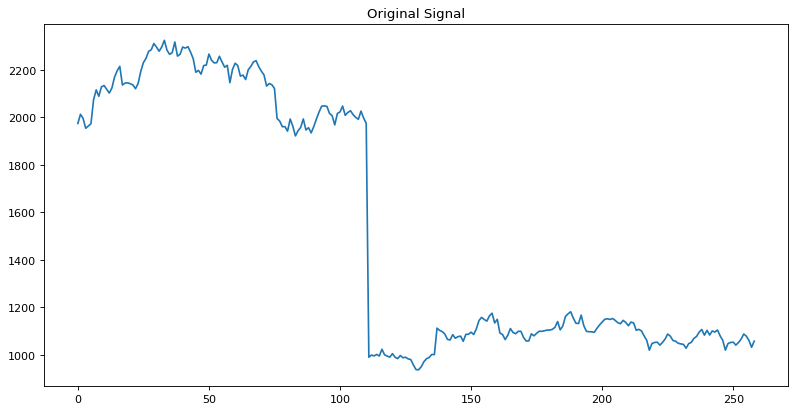

In [4]:
#displaying the original signal

figure(figsize=(12, 6), dpi=80)
x=np.arange(0,len(signal))
plt.plot(x,signal)
plt.title("Original Signal")
plt.show()

In [5]:
#defining a gaussian kernel that we will use to smooth the image before subsampling it, to avoid aliasing

def gauss(size, sigma):
    
    """
    Creates a Normalized 1D Gaussian kernel that can be convolved 
    with signal to get the differented image.  The normalization will 
    ensure that derivatives are not scaled up or down. 
    
    Parameters
    ----------
    size,sigma : integers
        size of output Gaussian kernel using sigma value provided
    
    Returns
    -------
    g : ndarray
        normalized Gaussian kernel
    
    Examples
    --------
    >>> gauss(5,3)
    array([ 0.19299951,  0.11400099, -0. , -0.11400099, -0.19299951])
    >>> gauss(9,3)
    array([ 0.05080013,  0.05621062,  0.04947257,  0.02922247, -0.,
       -0.02922247, -0.04947257, -0.05621062, -0.05080013])
    
    """

    x = np.mgrid[-size//2 + 1:size//2 + 1]
    g = (np.exp(- 0.5 * (x / sigma) ** 2))
    return g/np.sum(g)

In [6]:
def subsampling(image,s):
        
    """
    Subsamples an image. Retains sth element of an image, smoothed with Gaussian 
    filter. Divided into two cases, when s is an integer and when it is not.
    When s is not an integer, we subsample according to formulation discussed
    in the theory.
    
    
    Parameters
    ----------
    image : ndarray
        the input 1D image
    s: integer/float
        sampling factor, defined as sigma/1.6
        
    Returns
    -------
    arr : ndarray
        subsampled output 1D image
    
    """
    arr=[]
    if type(s)==int:
        for i in range(len(image)):
            if i%s==0:
                arr.append(image[i])
    if type(s)!=int:
        for i in range(len(image)):
            if i<len(image)-1:
                epsilon=np.floor(s)
                if i%epsilon==0:
                    delta_x=s-epsilon
                    arr.append(image[i]*(1-delta_x)+image[i+1]*delta_x)
            elif i>len(image)-1:
                pass
    return arr

In [7]:
#function to plot the image pyramid

def plot_pyramid_signal(image,sigma):
    s=sigma/1.6
    l=int((len(image)-1)**(1/s))
    gaussian_kernel=gauss(9, sigma)
    image_0=image
    
    for i in range(1,l+1):
        figure(figsize=(12/i, 20), dpi=80)
        plt.subplot(l+1, 1, i + 1)
        plt.ylim([0, 2500])
        x=np.arange(0,len(image_0))
        plt.plot(x,image_0)
        plt.show()
        image_smoothed=np.convolve(image_0,gaussian_kernel)
        image_sampled=subsampling(image_smoothed,s)

        image_0=image_sampled

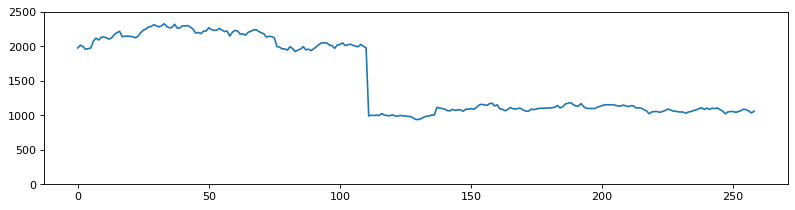

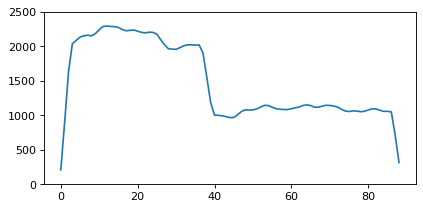

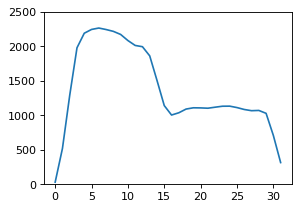

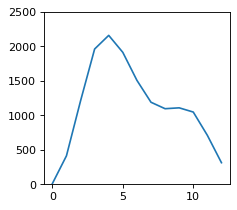

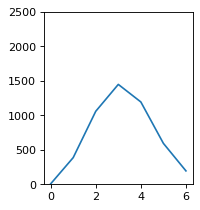

In [8]:
plot_pyramid_signal(signal,5)

## Plotting another example for a sine curve

In [9]:
y=np.arange(0,4*np.pi,0.1)
sin_curve=np.sin(y)

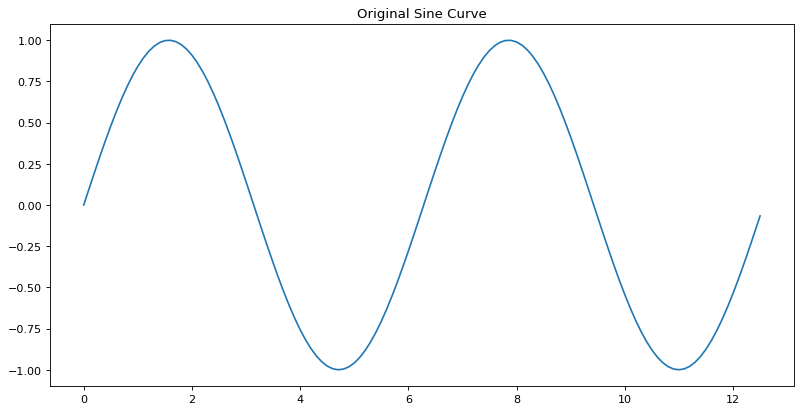

In [10]:
figure(figsize=(12, 6), dpi=80)
x=np.arange(0,len(signal))
plt.plot(y,sin_curve)
plt.title("Original Sine Curve")
plt.show()

In [13]:
#function to plot the image pyramid for sine curve

def plot_pyramid_sine(image,sigma):
    s=sigma/1.6
    l=int((len(image)-1)**(1/s))
    gaussian_kernel=gauss(9, sigma)
    image_0=image
    
    for i in range(1,l+1):
        figure(figsize=(12/i, 20), dpi=80)
        plt.subplot(l+1, 1, i + 1)
        plt.ylim([min(image)-0.2, max(image)+0.2])
        x=np.arange(0,len(image_0))
        plt.plot(x,image_0)
        plt.show()
        image_smoothed=np.convolve(image_0,gaussian_kernel)
        image_sampled=subsampling(image_smoothed,s)

        image_0=image_sampled

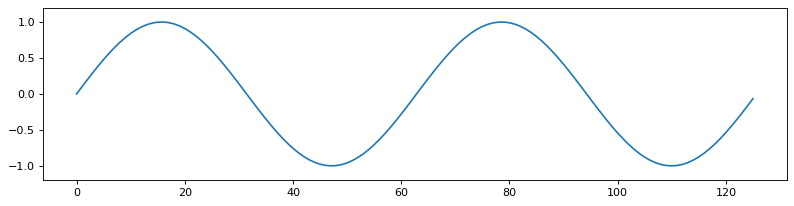

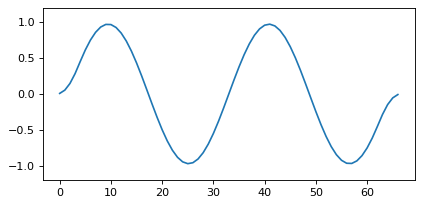

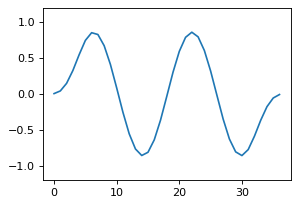

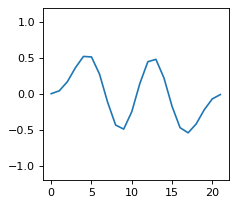

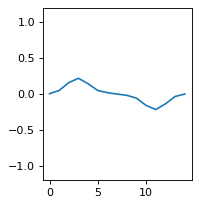

In [15]:
plot_pyramid_sine(sin_curve,4.5)

### References:

1. Duke University CS 527 Computer Vision: https://courses.cs.duke.edu//spring22/compsci527/notes/n_02_differentiation.pdf


2. Hacettepe University BBM 413: https://web.cs.hacettepe.edu.tr/~erkut/bbm413.f16/slides/09-pyramids.pdf


3. Pyrtools documentation/tutorial: https://pyrtools.readthedocs.io/en/latest/tutorials/tutorial2.html


4. University of Toronto CSC 320: https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf